In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.makedirs('/content/drive/MyDrive/sentiment_project', exist_ok=True)


Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentiment_project/processed_reviews_2m.csv')

In [ ]:
df.info()
df.describe()
df.shape
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999670 entries, 0 to 1999669
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   rating             float64
 1   title              object 
 2   text               object 
 3   timestamp          int64  
 4   helpful_vote       int64  
 5   verified_purchase  int64  
 6   label              object 
 7   full_text          object 
dtypes: float64(1), int64(3), object(4)
memory usage: 122.1+ MB


,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...


In [ ]:
X_text = df['full_text']
X_extra = df[['verified_purchase', 'helpful_vote']]  # optional
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

***Vectorization TF-IDF Selection par chi*** **2**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english') # the number of features should not be initialized
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test) # une transformation en se basant sur le vocabulaire appris du train not the new words in the test set

In [ ]:
# selection des 'features' avec chi 2
from sklearn.feature_selection import SelectKBest, chi2

# le fit : sélectionner les 300 features avec les scores chi² les plus élevés
# le transform :  supprimer toutes les cfeatures qui ne font pas partie des 300 retenues
selector = SelectKBest(score_func=chi2, k=300)
X_train_selected = selector.fit_transform(X_train_vec, y_train)

X_test_selected = selector.transform(X_test_vec)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: LinearSVC with Class Weight Balancing")

target_names = ['negative', 'neutral', 'positive']


svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

start_time = time.time()
svm_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time

print(f"Training took {train_time/60:.2f} minutes")

y_pred_svm = svm_model.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=target_names)}")

# Cross-validation (5 folds)
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: LinearSVC with Class Weight Balancing
Training took 0.94 minutes
Accuracy: 0.8198
F1 Score (macro): 0.6467
Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     78985
     neutral       0.42      0.25      0.32     38364
    positive       0.88      0.92      0.90    282585

    accuracy                           0.82    399934
   macro avg       0.67      0.64      0.65    399934
weighted avg       0.80      0.82      0.81    399934

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6457 (+/- 0.0018)


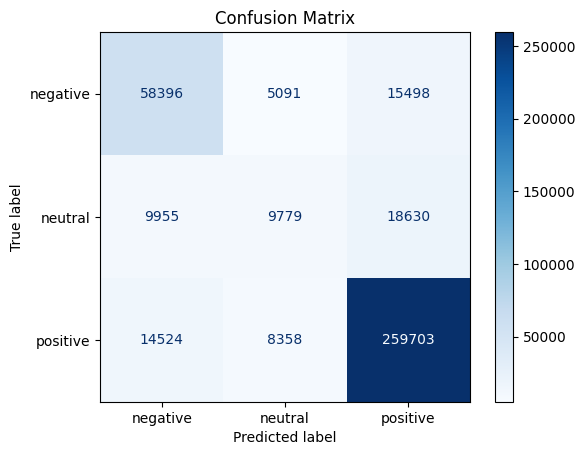

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/svm_model_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_chi2.joblib']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: Logistic Regression with Class Weight Balancing")

# Define class labels (ensure same order as LabelEncoder)
target_names = ['negative', 'neutral', 'positive']

# Create model with solver optimized for large datasets
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='saga',          # Good for large data + supports L1/L2 penalties
    n_jobs=-1               # Use all cores during fitting
)

# Train model and track training time
start_time = time.time()
lr_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time / 60:.2f} minutes")

# Predict
y_pred_lr = lr_model.predict(X_test_selected)

# Evaluation
acc = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=target_names)}")

# Cross-validation (parallelized)
cv_scores = cross_val_score(
    lr_model,
    X_train_selected,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Logistic Regression with Class Weight Balancing
Training took 1.15 minutes
Accuracy: 0.7197
F1 Score (macro): 0.6227
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.71      0.72     78985
     neutral       0.22      0.58      0.32     38364
    positive       0.95      0.74      0.83    282585

    accuracy                           0.72    399934
   macro avg       0.63      0.68      0.62    399934
weighted avg       0.83      0.72      0.76    399934

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6214 (+/- 0.0007)


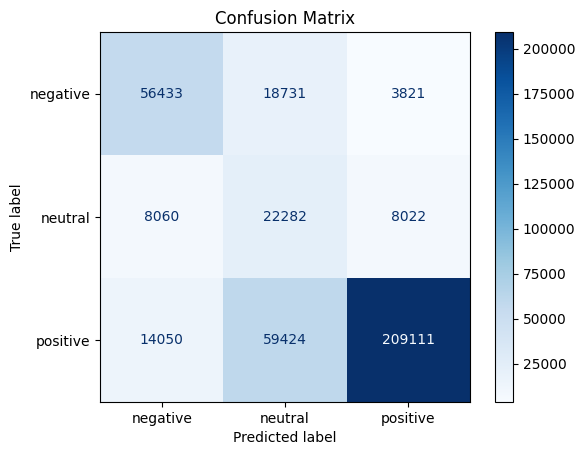

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
joblib.dump(lr_model, '/content/drive/MyDrive/sentiment_project/lr_model_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/lr_model_chi2.joblib']

***Vectorization TF-IDF Selection par ACP***

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.transform(X_test_vec)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: LinearSVC with Class Weight Balancing")

target_names = ['negative', 'neutral', 'positive']

svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

start_time = time.time()
svm_model.fit(X_train_reduced, y_train)
train_time = time.time() - start_time

print(f"Training took {train_time/60:.2f} minutes")

y_pred_svm = svm_model.predict(X_test_reduced)

acc = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=target_names)}")

# Cross-validation (5 folds)
cv_scores = cross_val_score(svm_model, X_train_reduced, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: LinearSVC with Class Weight Balancing
Training took 2.67 minutes
Accuracy: 0.7941
F1 Score (macro): 0.6184
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.80      0.69     78985
     neutral       0.39      0.22      0.28     38364
    positive       0.90      0.87      0.88    282585

    accuracy                           0.79    399934
   macro avg       0.63      0.63      0.62    399934
weighted avg       0.79      0.79      0.79    399934



TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [ ]:
import joblib
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/svm_model_acp.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_acp.joblib']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: Logistic Regression with Class Weight Balancing (on SVD-reduced TF-IDF)")

# Define class labels (make sure this matches your label encoding)
target_names = ['negative', 'neutral', 'positive']

# Create the model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='saga',     # good for large sparse data & supports regularization
    n_jobs=-1          # utilize all CPUs
)

# Train and time it
start_time = time.time()
lr_model.fit(X_train_reduced, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time / 60:.2f} minutes")

# Predict
y_pred_lr = lr_model.predict(X_test_reduced)

# Evaluate
acc = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=target_names)}")

# Cross-validation
cv_scores = cross_val_score(
    lr_model,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Logistic Regression with Class Weight Balancing (on SVD-reduced TF-IDF)
Training took 3.09 minutes
Accuracy: 0.7115
F1 Score (macro): 0.6074
Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.77      0.68     78985
     neutral       0.23      0.52      0.32     38364
    positive       0.94      0.72      0.82    282585

    accuracy                           0.71    399934
   macro avg       0.60      0.67      0.61    399934
weighted avg       0.81      0.71      0.74    399934

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6073 (+/- 0.0010)


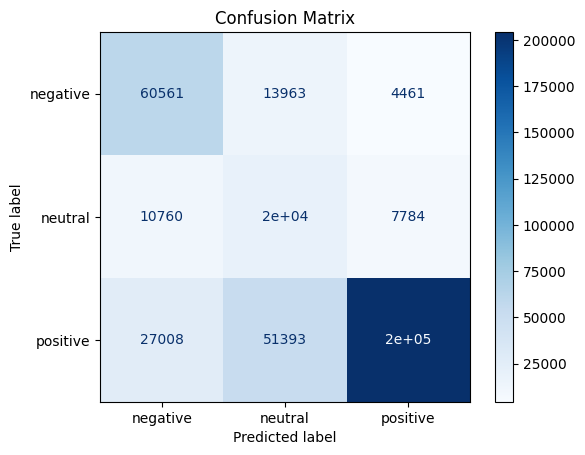

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
cm2

array([[ 60561,  13963,   4461],
       [ 10760,  19820,   7784],
       [ 27008,  51393, 204184]])

In [ ]:
import joblib
joblib.dump(lr_model, '/content/drive/MyDrive/sentiment_project/lr_model_acp.joblib')

['/content/drive/MyDrive/sentiment_project/lr_model_acp.joblib']